# Imports and General Settings

In [1]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


/device:GPU:0


# Data Augmentation

In [7]:
# data augmentation methods in data_augmentation_utility.py

# choose augmentation in load_data_utility.py

# ConvNet

## ConvNet Architecture

In [2]:
num_classes = 3

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 1)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

num_steps = 10000

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/with_data_aug/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["original_initial_labels", "original_new_labels", "train_set_balanced", "whole_set_balanced" ]

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                print(train_root)
                
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=True, batch_size=32, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set + "/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

./data/generated_splits/original_initial_labels/train/
/data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c87f1c710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training an

INFO:tensorflow:Finished evaluation at 2019-08-07-18:34:38
INFO:tensorflow:Saving dict for global step 425: accuracy = 0.39506173, global_step = 425, loss = 5.991312
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 425: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-425
INFO:tensorflow:global_step/sec: 2.73908
INFO:tensorflow:loss = 3.067521, step = 440 (7.303 sec)
INFO:tensorflow:global_step/sec: 2.86714
INFO:tensorflow:loss = 0.5411151, step = 460 (6.973 sec)
INFO:tensorflow:global_step/sec: 2.89664
INFO:tensorflow:loss = 0.253848, step = 480 (6.907 sec)
INFO:tensorflow:global_step/sec: 2.85762
INFO:tensorflow:loss = 0.56743526, step = 500 (6.998 sec)
INFO:tensorflow:Saving checkpoints for 511 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-18:35:07
INFO:t

INFO:tensorflow:global_step/sec: 2.85537
INFO:tensorflow:loss = 1.8582865, step = 1000 (7.002 sec)
INFO:tensorflow:Saving checkpoints for 1021 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-18:38:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-1021
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-18:38:08
INFO:tensorflow:Saving dict for global step 1021: accuracy = 0.34567901, global_step = 1021, loss = 6.881744
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1021: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-1021
INFO:tensorflow:global_step/sec: 2.18416


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-18:41:10
INFO:tensorflow:Saving dict for global step 1534: accuracy = 0.4074074, global_step = 1534, loss = 5.2377243
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1534: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-1534
INFO:tensorflow:global_step/sec: 2.81787
INFO:tensorflow:loss = 0.3435346, step = 1540 (7.097 sec)
INFO:tensorflow:global_step/sec: 2.77031
INFO:tensorflow:loss = 0.110293284, step = 1560 (7.222 sec)
INFO:tensorflow:global_step/sec: 2.84776
INFO:tensorflow:loss = 1.413238, step = 1580 (7.022 sec)
INFO:tensorflow:global_step/sec: 2.84128
INFO:tensorflow:loss = 0.26133373, step = 1600 (7.041 sec)
INFO:tensorflow:Saving checkpoints for 1619 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tens

INFO:tensorflow:loss = 0.18289885, step = 2060 (7.407 sec)
INFO:tensorflow:global_step/sec: 2.87229
INFO:tensorflow:loss = 0.1040255, step = 2080 (6.964 sec)
INFO:tensorflow:global_step/sec: 2.89462
INFO:tensorflow:loss = 0.27670473, step = 2100 (6.910 sec)
INFO:tensorflow:global_step/sec: 2.89946
INFO:tensorflow:loss = 0.27368692, step = 2120 (6.896 sec)
INFO:tensorflow:Saving checkpoints for 2136 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-18:44:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-2136
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-18:44:41
INFO:tensorflow:Saving dict for global step 2136: ac

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-18:47:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-2649
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-18:47:42
INFO:tensorflow:Saving dict for global step 2649: accuracy = 0.3580247, global_step = 2649, loss = 3.9770114
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2649: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-2649
INFO:tensorflow:global_step/sec: 2.85527
INFO:tensorflow:loss = 0.04719869, step = 2660 (7.002 sec)
INFO:tensorflow:global_step/sec: 2.85909
INFO:tensorflow:loss = 0.028800402, step = 2680 (6.997 sec)
INFO:tensorflow:global_step/sec: 2.85023
INFO:tensorflow:loss = 0.00444159

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3161: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-3161
INFO:tensorflow:global_step/sec: 2.15336
INFO:tensorflow:loss = 0.04978624, step = 3160 (9.287 sec)
INFO:tensorflow:global_step/sec: 4.11949
INFO:tensorflow:loss = 0.014070206, step = 3180 (4.857 sec)
INFO:tensorflow:global_step/sec: 2.89008
INFO:tensorflow:loss = 0.042337704, step = 3200 (6.922 sec)
INFO:tensorflow:global_step/sec: 2.85093
INFO:tensorflow:loss = 0.025654657, step = 3220 (7.012 sec)
INFO:tensorflow:global_step/sec: 2.93784
INFO:tensorflow:loss = 0.0070026224, step = 3240 (6.809 sec)
INFO:tensorflow:Saving checkpoints for 3248 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-18:51:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Re

INFO:tensorflow:global_step/sec: 2.60565
INFO:tensorflow:loss = 0.012921397, step = 3740 (7.672 sec)
INFO:tensorflow:Saving checkpoints for 3761 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-18:54:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-3761
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-18:54:15
INFO:tensorflow:Saving dict for global step 3761: accuracy = 0.4074074, global_step = 3761, loss = 3.826212
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3761: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-3761
INFO:tensorflow:global_step/sec: 2.17057

INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-4274
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-18:57:16
INFO:tensorflow:Saving dict for global step 4274: accuracy = 0.41975307, global_step = 4274, loss = 3.7801516
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4274: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-4274
INFO:tensorflow:global_step/sec: 2.84991
INFO:tensorflow:loss = 0.2718699, step = 4280 (7.017 sec)
INFO:tensorflow:global_step/sec: 2.87355
INFO:tensorflow:loss = 0.055285707, step = 4300 (6.960 sec)
INFO:tensorflow:global_step/sec: 2.92612
INFO:tensorflow:loss = 0.002299194, step = 4320 (6.839 sec)
INFO:tensorflow:global_step/sec: 2.89451
INFO:tensorflow:loss = 0.0044379784, step = 4340 (6.906 sec)
INFO:tensorflow:Saving checkpoints for 4361 into /da

INFO:tensorflow:global_step/sec: 2.8337
INFO:tensorflow:loss = 0.0107466895, step = 4800 (7.057 sec)
INFO:tensorflow:global_step/sec: 2.87572
INFO:tensorflow:loss = 0.003969803, step = 4820 (6.956 sec)
INFO:tensorflow:global_step/sec: 2.89665
INFO:tensorflow:loss = 0.041414537, step = 4840 (6.904 sec)
INFO:tensorflow:global_step/sec: 2.96606
INFO:tensorflow:loss = 0.0046935966, step = 4860 (6.742 sec)
INFO:tensorflow:Saving checkpoints for 4879 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:00:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-4879
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:00:47
INFO:

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:03:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-5395
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:03:48
INFO:tensorflow:Saving dict for global step 5395: accuracy = 0.4074074, global_step = 5395, loss = 3.6818447
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5395: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-5395
INFO:tensorflow:global_step/sec: 2.81983
INFO:tensorflow:loss = 0.0036535976, step = 5400 (7.093 sec)
INFO:tensorflow:global_step/sec: 2.99015
INFO:tensorflow:loss = 0.004688478, step = 5420 (6.688 sec)
INFO:tensorflow:global_step/sec: 2.88695
INFO:tensorflow:loss = 0.007791

INFO:tensorflow:loss = 0.000430585, step = 5980 (6.847 sec)
INFO:tensorflow:Saving checkpoints for 5997 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:07:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-5997
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:07:19
INFO:tensorflow:Saving dict for global step 5997: accuracy = 0.37037036, global_step = 5997, loss = 3.6131814
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5997: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-5997
INFO:tensorflow:global_step/sec: 2.45402
INFO:tensorflow:loss = 0.031392634, st

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:10:20
INFO:tensorflow:Saving dict for global step 6515: accuracy = 0.41975307, global_step = 6515, loss = 3.6223767
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6515: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-6515
INFO:tensorflow:global_step/sec: 2.62395
INFO:tensorflow:loss = 0.0023822817, step = 6520 (7.622 sec)
INFO:tensorflow:global_step/sec: 2.97997
INFO:tensorflow:loss = 0.07913028, step = 6540 (6.714 sec)
INFO:tensorflow:global_step/sec: 2.79556
INFO:tensorflow:loss = 0.00032027296, step = 6560 (7.153 sec)
INFO:tensorflow:global_step/sec: 2.86382
INFO:tensorflow:loss = 0.018483544, step = 6580 (6.983 sec)
INFO:tensorflow:Saving checkpoints for 6600 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part


INFO:tensorflow:loss = 0.07093076, step = 7040 (7.305 sec)
INFO:tensorflow:global_step/sec: 2.90245
INFO:tensorflow:loss = 0.0043847915, step = 7060 (6.890 sec)
INFO:tensorflow:global_step/sec: 2.81318
INFO:tensorflow:loss = 0.13714555, step = 7080 (7.110 sec)
INFO:tensorflow:global_step/sec: 2.91858
INFO:tensorflow:loss = 0.005489292, step = 7100 (6.853 sec)
INFO:tensorflow:Saving checkpoints for 7116 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:13:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-7116
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:13:52
INFO:tensorflow:Saving dict for global step 7116

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:16:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-7633
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:16:53
INFO:tensorflow:Saving dict for global step 7633: accuracy = 0.39506173, global_step = 7633, loss = 3.780879
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7633: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-7633
INFO:tensorflow:global_step/sec: 2.79896
INFO:tensorflow:loss = 0.0014029983, step = 7640 (7.145 sec)
INFO:tensorflow:global_step/sec: 2.8995
INFO:tensorflow:loss = 0.011556126, step = 7660 (6.898 sec)
INFO:tensorflow:global_step/sec: 2.93253
INFO:tensorflow:loss = 0.0004382

INFO:tensorflow:Saving dict for global step 8153: accuracy = 0.41975307, global_step = 8153, loss = 3.85521
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8153: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-8153
INFO:tensorflow:global_step/sec: 2.73157
INFO:tensorflow:loss = 0.061617512, step = 8160 (7.322 sec)
INFO:tensorflow:global_step/sec: 2.89467
INFO:tensorflow:loss = 0.00042625796, step = 8180 (6.912 sec)
INFO:tensorflow:global_step/sec: 2.89378
INFO:tensorflow:loss = 0.030647272, step = 8200 (6.908 sec)
INFO:tensorflow:global_step/sec: 2.86158
INFO:tensorflow:loss = 0.00048629424, step = 8220 (6.993 sec)
INFO:tensorflow:Saving checkpoints for 8239 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:20:22
INFO:tensorflow:Graph was finalized.
INFO:te

INFO:tensorflow:loss = 0.057160676, step = 8700 (6.953 sec)
INFO:tensorflow:global_step/sec: 2.8765
INFO:tensorflow:loss = 0.0021495775, step = 8720 (6.953 sec)
INFO:tensorflow:global_step/sec: 2.93114
INFO:tensorflow:loss = 0.0047081276, step = 8740 (6.821 sec)
INFO:tensorflow:Saving checkpoints for 8758 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:23:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-8758
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:23:25
INFO:tensorflow:Saving dict for global step 8758: accuracy = 0.43209878, global_step = 8758, loss = 4.5008426
INFO:tensorflow:Saving 'checkpoint_pa

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:26:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-9275
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:26:25
INFO:tensorflow:Saving dict for global step 9275: accuracy = 0.43209878, global_step = 9275, loss = 4.418907
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9275: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-9275
INFO:tensorflow:global_step/sec: 2.73882
INFO:tensorflow:loss = 0.00018379958, step = 9280 (7.302 sec)
INFO:tensorflow:global_step/sec: 2.95076
INFO:tensorflow:loss = 0.00029526977, step = 9300 (6.780 sec)
INFO:tensorflow:global_step/sec: 2.89979
INFO:tensorflow:loss = 0.000

INFO:tensorflow:Finished evaluation at 2019-08-07-19:29:26
INFO:tensorflow:Saving dict for global step 9795: accuracy = 0.38271606, global_step = 9795, loss = 4.6205063
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9795: /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt-9795
INFO:tensorflow:global_step/sec: 2.67019
INFO:tensorflow:loss = 0.0011168424, step = 9800 (7.489 sec)
INFO:tensorflow:global_step/sec: 3.0027
INFO:tensorflow:loss = 0.0005087279, step = 9820 (6.663 sec)
INFO:tensorflow:global_step/sec: 2.90861
INFO:tensorflow:loss = 0.00026677566, step = 9840 (6.874 sec)
INFO:tensorflow:global_step/sec: 2.93581
INFO:tensorflow:loss = 0.22260973, step = 9860 (6.812 sec)
INFO:tensorflow:global_step/sec: 2.92764
INFO:tensorflow:loss = 0.0032390808, step = 9880 (6.831 sec)
INFO:tensorflow:Saving checkpoints for 9882 into /data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/model.ckpt.
INFO:tensorflow:Skip the cu

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:32:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-289
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:32:13
INFO:tensorflow:Saving dict for global step 289: accuracy = 0.549763, global_step = 289, loss = 6.796963
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 289: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-289
INFO:tensorflow:global_step/sec: 2.84909
INFO:tensorflow:loss = 0.1736537, step = 300 (7.018 sec)
INFO:tensorflow:global_step/sec: 3.26208
INFO:tensorflow:loss = 0.36533132, step = 320 (6.133 sec)
INFO:tensorflow:global_step/sec: 3.41652
INFO:tensorflow:loss = 0.12768288, step = 340 (5.853

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:35:14
INFO:tensorflow:Saving dict for global step 867: accuracy = 0.578199, global_step = 867, loss = 7.242471
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 867: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-867
INFO:tensorflow:global_step/sec: 2.65405
INFO:tensorflow:loss = 3.7074788e-05, step = 880 (7.536 sec)
INFO:tensorflow:global_step/sec: 3.39801
INFO:tensorflow:loss = 0.00044998253, step = 900 (5.889 sec)
INFO:tensorflow:global_step/sec: 3.19923
INFO:tensorflow:loss = 0.005970203, step = 920 (6.256 sec)
INFO:tensorflow:global_step/sec: 3.40029
INFO:tensorflow:loss = 0.0026640757, step = 940 (5.875 sec)
INFO:tensorflow:global_step/sec: 3.21657
INFO:tensorflow:loss = 0.05167256, step = 960 (6.220 sec)
INFO:tensorflow:Saving checkpoints for 962 into /data/jma/model/dataset_experiments/with_data_

INFO:tensorflow:global_step/sec: 2.34058
INFO:tensorflow:loss = 0.00013369307, step = 1440 (8.546 sec)
INFO:tensorflow:global_step/sec: 4.64711
INFO:tensorflow:loss = 2.062386e-05, step = 1460 (4.304 sec)
INFO:tensorflow:global_step/sec: 3.25709
INFO:tensorflow:loss = 6.9320636e-06, step = 1480 (6.139 sec)
INFO:tensorflow:global_step/sec: 3.22981
INFO:tensorflow:loss = 3.255749e-06, step = 1500 (6.194 sec)
INFO:tensorflow:global_step/sec: 3.3608
INFO:tensorflow:loss = 1.0321196e-05, step = 1520 (5.952 sec)
INFO:tensorflow:Saving checkpoints for 1537 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:38:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-1537
INFO:tensorflow:Running local_init_op.
INFO:tens

INFO:tensorflow:loss = 7.248594e-06, step = 2040 (6.003 sec)
INFO:tensorflow:global_step/sec: 3.21938
INFO:tensorflow:loss = 3.72529e-09, step = 2060 (6.211 sec)
INFO:tensorflow:global_step/sec: 3.35793
INFO:tensorflow:loss = 1.4335614e-05, step = 2080 (5.955 sec)
INFO:tensorflow:global_step/sec: 3.18009
INFO:tensorflow:loss = 1.2169345e-05, step = 2100 (6.293 sec)
INFO:tensorflow:Saving checkpoints for 2109 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:41:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-2109
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:41:46
INFO:tensorflow:Saving dict for global step 2109: 

INFO:tensorflow:global_step/sec: 3.30216
INFO:tensorflow:loss = 5.036264e-06, step = 2660 (6.056 sec)
INFO:tensorflow:global_step/sec: 3.34921
INFO:tensorflow:loss = 9.51381e-06, step = 2680 (5.974 sec)
INFO:tensorflow:Saving checkpoints for 2683 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:44:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-2683
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:44:47
INFO:tensorflow:Saving dict for global step 2683: accuracy = 0.578199, global_step = 2683, loss = 7.847192
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2683: /data/jma/model/dataset_experiments/w

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:47:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-3259
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:47:48
INFO:tensorflow:Saving dict for global step 3259: accuracy = 0.578199, global_step = 3259, loss = 7.8590493
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3259: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-3259
INFO:tensorflow:global_step/sec: 2.43005
INFO:tensorflow:loss = 5.2898724e-07, step = 3260 (8.230 sec)
INFO:tensorflow:global_step/sec: 4.13348
INFO:tensorflow:loss = 3.9523306e-06, step = 3280 (4.838 sec)
INFO:tensorflow:global_step/sec: 3.36904
INFO:tensorflow:loss = 5.5879333e-08,

INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-3833
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:50:49
INFO:tensorflow:Saving dict for global step 3833: accuracy = 0.578199, global_step = 3833, loss = 7.8786073
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3833: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-3833
INFO:tensorflow:global_step/sec: 2.81788
INFO:tensorflow:loss = 3.1292325e-07, step = 3840 (7.099 sec)
INFO:tensorflow:global_step/sec: 3.37827
INFO:tensorflow:loss = 4.492596e-06, step = 3860 (5.919 sec)
INFO:tensorflow:global_step/sec: 3.2748
INFO:tensorflow:loss = 1.6540014e-06, step = 3880 (6.109 sec)
INFO:tensorflow:global_step/sec: 3.4266
INFO:tensorflow:loss = 1.251696e-06, step = 3900 (5.836 sec)
INFO:tensorflow:global_step/sec: 3.21366
INFO:tensorflow:

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-19:53:50
INFO:tensorflow:Saving dict for global step 4408: accuracy = 0.578199, global_step = 4408, loss = 7.900207
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4408: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-4408
INFO:tensorflow:global_step/sec: 2.88217
INFO:tensorflow:loss = 2.5666777e-06, step = 4420 (6.940 sec)
INFO:tensorflow:global_step/sec: 3.21675
INFO:tensorflow:loss = 2.0935788e-06, step = 4440 (6.218 sec)
INFO:tensorflow:global_step/sec: 3.20395
INFO:tensorflow:loss = 1.0803332e-07, step = 4460 (6.243 sec)
INFO:tensorflow:global_step/sec: 3.41101
INFO:tensorflow:loss = 2.942967e-07, step = 4480 (5.863 sec)
INFO:tensorflow:global_step/sec: 3.21448
INFO:tensorflow:loss = 1.9892864e-06, step = 4500 (6.222 sec)
INFO:tensorflow:Saving checkpoints for 4504 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4983: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-4983
INFO:tensorflow:global_step/sec: 2.8661
INFO:tensorflow:loss = 1.1175856e-07, step = 5000 (6.976 sec)
INFO:tensorflow:global_step/sec: 3.17732
INFO:tensorflow:loss = 1.9892832e-06, step = 5020 (6.297 sec)
INFO:tensorflow:global_step/sec: 3.4161
INFO:tensorflow:loss = 2.5368872e-06, step = 5040 (5.854 sec)
INFO:tensorflow:global_step/sec: 3.23544
INFO:tensorflow:loss = 3.948721e-06, step = 5060 (6.180 sec)
INFO:tensorflow:Saving checkpoints for 5079 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-19:57:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt

INFO:tensorflow:global_step/sec: 3.93916
INFO:tensorflow:loss = 6.258429e-07, step = 5580 (5.078 sec)
INFO:tensorflow:global_step/sec: 3.27931
INFO:tensorflow:loss = 2.06378e-06, step = 5600 (6.100 sec)
INFO:tensorflow:global_step/sec: 3.2521
INFO:tensorflow:loss = 3.72529e-09, step = 5620 (6.148 sec)
INFO:tensorflow:global_step/sec: 3.445
INFO:tensorflow:loss = 6.5192376e-07, step = 5640 (5.807 sec)
INFO:tensorflow:Saving checkpoints for 5654 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:00:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-5654
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:00:22
INFO:tensorflo

INFO:tensorflow:global_step/sec: 3.32561
INFO:tensorflow:loss = 1.2293448e-07, step = 6200 (6.016 sec)
INFO:tensorflow:global_step/sec: 3.39208
INFO:tensorflow:loss = 7.45058e-09, step = 6220 (5.894 sec)
INFO:tensorflow:Saving checkpoints for 6231 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:03:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-6231
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:03:23
INFO:tensorflow:Saving dict for global step 6231: accuracy = 0.5829384, global_step = 6231, loss = 7.9559526
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6231: /data/jma/model/dataset_experiment

INFO:tensorflow:Saving checkpoints for 6809 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:06:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-6809
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:06:23
INFO:tensorflow:Saving dict for global step 6809: accuracy = 0.5829384, global_step = 6809, loss = 7.9700737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6809: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-6809
INFO:tensorflow:global_step/sec: 2.76893
INFO:tensorflow:loss = 7.5623063e-07, step = 6820 (7.223 sec)
INFO:tensorflow:global_step/sec: 3.28917
INFO:ten

INFO:tensorflow:global_step/sec: 2.8414
INFO:tensorflow:loss = 7.934845e-07, step = 7400 (7.038 sec)
INFO:tensorflow:global_step/sec: 3.25622
INFO:tensorflow:loss = 3.4645137e-07, step = 7420 (6.142 sec)
INFO:tensorflow:global_step/sec: 3.42277
INFO:tensorflow:loss = 3.799788e-07, step = 7440 (5.847 sec)
INFO:tensorflow:global_step/sec: 3.26026
INFO:tensorflow:loss = 3.3527606e-08, step = 7460 (6.131 sec)
INFO:tensorflow:global_step/sec: 3.39446
INFO:tensorflow:loss = 3.6135248e-07, step = 7480 (5.892 sec)
INFO:tensorflow:Saving checkpoints for 7486 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:09:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-7486
INFO:tensorflow:Running local_init_op.
INFO:tens

INFO:tensorflow:loss = 2.4214356e-07, step = 8000 (5.831 sec)
INFO:tensorflow:global_step/sec: 3.26308
INFO:tensorflow:loss = 7.413307e-07, step = 8020 (6.127 sec)
INFO:tensorflow:global_step/sec: 3.3351
INFO:tensorflow:loss = 3.389997e-07, step = 8040 (5.998 sec)
INFO:tensorflow:global_step/sec: 3.27844
INFO:tensorflow:loss = 5.2898963e-07, step = 8060 (6.102 sec)
INFO:tensorflow:Saving checkpoints for 8064 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:12:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-8064
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:12:55
INFO:tensorflow:Saving dict for global step 8064: 

INFO:tensorflow:global_step/sec: 3.17281
INFO:tensorflow:loss = 4.172311e-07, step = 8620 (6.306 sec)
INFO:tensorflow:Saving checkpoints for 8640 into /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:15:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-8640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:15:56
INFO:tensorflow:Saving dict for global step 8640: accuracy = 0.5829384, global_step = 8640, loss = 8.022573
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8640: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-8640
INFO:tensorflow:global_step/sec: 2.15635
INFO:tenso

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:18:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-9213
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:18:57
INFO:tensorflow:Saving dict for global step 9213: accuracy = 0.5829384, global_step = 9213, loss = 8.035631
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9213: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-9213
INFO:tensorflow:global_step/sec: 2.93184
INFO:tensorflow:loss = 1.0430804e-07, step = 9220 (6.820 sec)
INFO:tensorflow:global_step/sec: 3.24903
INFO:tensorflow:loss = 1.1175869e-08, step = 9240 (6.157 sec)
INFO:tensorflow:global_step/sec: 3.39184
INFO:tensorflow:loss = 4.7311002e-07,

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-9790
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:21:59
INFO:tensorflow:Saving dict for global step 9790: accuracy = 0.5876777, global_step = 9790, loss = 8.055079
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9790: /data/jma/model/dataset_experiments/with_data_aug/original_new_labels/model.ckpt-9790
INFO:tensorflow:global_step/sec: 2.66483
INFO:tensorflow:loss = 3.7252892e-08, step = 9800 (7.505 sec)
INFO:tensorflow:global_step/sec: 3.08468
INFO:tensorflow:loss = 0.0, step = 9820 (6.482 sec)
INFO:tensorflow:global_step/sec: 3.2353
INFO:tensorflow:loss = 2.5704475e-07, step = 9840 (6.182 sec)
INFO:tensorflow:global_step/sec: 3.24139
INFO:tensorflow:loss = 1.8253905e-07, step = 9860 (6.172 sec)
INFO:tensorflow:global_step

INFO:tensorflow:Finished evaluation at 2019-08-07-20:24:11
INFO:tensorflow:Saving dict for global step 184: accuracy = 0.37914693, global_step = 184, loss = 7.4256883
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 184: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-184
INFO:tensorflow:global_step/sec: 2.77648
INFO:tensorflow:loss = 0.18773572, step = 200 (7.201 sec)
INFO:tensorflow:global_step/sec: 3.14712
INFO:tensorflow:loss = 0.5265301, step = 220 (6.357 sec)
INFO:tensorflow:global_step/sec: 3.17884
INFO:tensorflow:loss = 0.91083354, step = 240 (6.291 sec)
INFO:tensorflow:global_step/sec: 3.11478
INFO:tensorflow:loss = 0.8030229, step = 260 (6.420 sec)
INFO:tensorflow:Saving checkpoints for 277 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:24:40
INFO:tensorf

INFO:tensorflow:global_step/sec: 3.11123
INFO:tensorflow:loss = 8.012073e-06, step = 780 (6.428 sec)
INFO:tensorflow:global_step/sec: 3.16575
INFO:tensorflow:loss = 0.0023257802, step = 800 (6.318 sec)
INFO:tensorflow:global_step/sec: 3.26299
INFO:tensorflow:loss = 0.0013006678, step = 820 (6.128 sec)
INFO:tensorflow:Saving checkpoints for 828 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:27:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-828
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:27:43
INFO:tensorflow:Saving dict for global step 828: accuracy = 0.44549763, global_step = 828, loss = 9.27395
INFO:tensorfl

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:30:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-1378
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:30:43
INFO:tensorflow:Saving dict for global step 1378: accuracy = 0.46445498, global_step = 1378, loss = 9.672444
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1378: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-1378
INFO:tensorflow:global_step/sec: 2.28455
INFO:tensorflow:loss = 4.1571525e-06, step = 1380 (8.753 sec)
INFO:tensorflow:global_step/sec: 3.74679
INFO:tensorflow:loss = 0.3165958, step = 1400 (5.337 sec)
INFO:tensorflow:global_step/sec: 3.23674
INFO:tensorflow:loss = 8.5680716e-07, step

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:33:44
INFO:tensorflow:Saving dict for global step 1930: accuracy = 0.46919432, global_step = 1930, loss = 13.99192
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1930: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-1930
INFO:tensorflow:global_step/sec: 2.72107
INFO:tensorflow:loss = 0.30086583, step = 1940 (7.347 sec)
INFO:tensorflow:global_step/sec: 3.25443
INFO:tensorflow:loss = 0.00079302414, step = 1960 (6.147 sec)
INFO:tensorflow:global_step/sec: 3.12534
INFO:tensorflow:loss = 1.1287459e-06, step = 1980 (6.399 sec)
INFO:tensorflow:global_step/sec: 3.10031
INFO:tensorflow:loss = 7.8231025e-08, step = 2000 (6.452 sec)
INFO:tensorflow:global_step/sec: 3.24678
INFO:tensorflow:loss = 0.0006310395, step = 2020 (6.159 sec)
INFO:tensorflow:Saving checkpoints for 2023 into /data/jma/model/dataset_experimen

INFO:tensorflow:global_step/sec: 2.67953
INFO:tensorflow:loss = 1.1920906e-07, step = 2500 (7.464 sec)
INFO:tensorflow:global_step/sec: 3.16969
INFO:tensorflow:loss = 0.035387598, step = 2520 (6.311 sec)
INFO:tensorflow:global_step/sec: 3.14372
INFO:tensorflow:loss = 0.3777658, step = 2540 (6.363 sec)
INFO:tensorflow:global_step/sec: 3.16139
INFO:tensorflow:loss = 0.4685552, step = 2560 (6.325 sec)
INFO:tensorflow:Saving checkpoints for 2579 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:37:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-2579
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:37:16
INFO:tensorflow:Sa

INFO:tensorflow:global_step/sec: 3.1785
INFO:tensorflow:loss = 0.15983568, step = 3120 (6.291 sec)
INFO:tensorflow:Saving checkpoints for 3133 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:40:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-3133
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:40:17
INFO:tensorflow:Saving dict for global step 3133: accuracy = 0.49289098, global_step = 3133, loss = 14.395114
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3133: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-3133
INFO:tensorflow:global_step/sec: 2.6839
INFO:tensorflow

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-3684
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:43:17
INFO:tensorflow:Saving dict for global step 3684: accuracy = 0.5450237, global_step = 3684, loss = 18.925709
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3684: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-3684
INFO:tensorflow:global_step/sec: 2.7968
INFO:tensorflow:loss = 0.0, step = 3700 (7.153 sec)
INFO:tensorflow:global_step/sec: 3.12461
INFO:tensorflow:loss = 0.0019382173, step = 3720 (6.400 sec)
INFO:tensorflow:global_step/sec: 3.17167
INFO:tensorflow:loss = 4.0978165e-08, step = 3740 (6.305 sec)
INFO:tensorflow:global_step/sec: 3.23868
INFO:tensorflow:loss = 5.5725386e-06, step = 3760 (6.175 sec)
INFO:tensorflow:Saving checkp

INFO:tensorflow:global_step/sec: 2.48513
INFO:tensorflow:loss = 2.9802315e-08, step = 4240 (8.046 sec)
INFO:tensorflow:global_step/sec: 3.58933
INFO:tensorflow:loss = 0.0004904332, step = 4260 (5.573 sec)
INFO:tensorflow:global_step/sec: 3.12832
INFO:tensorflow:loss = 0.00074108836, step = 4280 (6.392 sec)
INFO:tensorflow:global_step/sec: 3.23891
INFO:tensorflow:loss = 0.9080665, step = 4300 (6.175 sec)
INFO:tensorflow:global_step/sec: 3.15241
INFO:tensorflow:loss = 0.0, step = 4320 (6.345 sec)
INFO:tensorflow:Saving checkpoints for 4329 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:46:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-4329
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done ru

INFO:tensorflow:Saving checkpoints for 4879 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:49:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-4879
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:49:49
INFO:tensorflow:Saving dict for global step 4879: accuracy = 0.51184833, global_step = 4879, loss = 18.50729
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4879: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-4879
INFO:tensorflow:global_step/sec: 2.239
INFO:tensorflow:loss = 2.9802308e-08, step = 4880 (8.929 sec)
INFO:tensorflow:global_step/sec: 4.09852
INFO:tensorfl

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:52:50
INFO:tensorflow:Saving dict for global step 5431: accuracy = 0.48341233, global_step = 5431, loss = 18.636679
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5431: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-5431
INFO:tensorflow:global_step/sec: 2.70418
INFO:tensorflow:loss = 0.0002597321, step = 5440 (7.396 sec)
INFO:tensorflow:global_step/sec: 3.09124
INFO:tensorflow:loss = 0.4883513, step = 5460 (6.470 sec)
INFO:tensorflow:global_step/sec: 3.21586
INFO:tensorflow:loss = 6.7054935e-07, step = 5480 (6.218 sec)
INFO:tensorflow:global_step/sec: 3.21088
INFO:tensorflow:loss = 0.0, step = 5500 (6.229 sec)
INFO:tensorflow:global_step/sec: 3.20989
INFO:tensorflow:loss = 4.0978176e-08, step = 5520 (6.232 sec)
INFO:tensorflow:Saving checkpoints for 5523 into /data/jma/model/dataset_experiments/with_da

INFO:tensorflow:global_step/sec: 2.65502
INFO:tensorflow:loss = 0.0, step = 6000 (7.534 sec)
INFO:tensorflow:global_step/sec: 3.13582
INFO:tensorflow:loss = 5.513381e-07, step = 6020 (6.380 sec)
INFO:tensorflow:global_step/sec: 3.25891
INFO:tensorflow:loss = 0.0, step = 6040 (6.134 sec)
INFO:tensorflow:global_step/sec: 3.14724
INFO:tensorflow:loss = 1.4901158e-08, step = 6060 (6.356 sec)
INFO:tensorflow:Saving checkpoints for 6076 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:56:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-6076
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:56:21
INFO:tensorflow:Saving dict f

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-20:59:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-6626
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-20:59:22
INFO:tensorflow:Saving dict for global step 6626: accuracy = 0.5308057, global_step = 6626, loss = 20.37932
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6626: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-6626
INFO:tensorflow:global_step/sec: 2.74825
INFO:tensorflow:loss = 6.1839205e-07, step = 6640 (7.277 sec)
INFO:tensorflow:global_step/sec: 3.08913
INFO:tensorflow:loss = 3.799773e-07, step = 6660 (6.477 sec)
INFO:tensorflow:global_step/sec: 3.21622
INFO:tensorflow:loss = 0.0001800713, ste

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7178: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-7178
INFO:tensorflow:global_step/sec: 2.40299
INFO:tensorflow:loss = 0.0, step = 7180 (8.323 sec)
INFO:tensorflow:global_step/sec: 3.74994
INFO:tensorflow:loss = 0.0, step = 7200 (5.335 sec)
INFO:tensorflow:global_step/sec: 3.1038
INFO:tensorflow:loss = 0.0, step = 7220 (6.442 sec)
INFO:tensorflow:global_step/sec: 3.27453
INFO:tensorflow:loss = 0.0022509173, step = 7240 (6.108 sec)
INFO:tensorflow:global_step/sec: 3.12741
INFO:tensorflow:loss = 0.0, step = 7260 (6.396 sec)
INFO:tensorflow:Saving checkpoints for 7270 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-21:02:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/da

INFO:tensorflow:loss = 0.0, step = 7800 (6.370 sec)
INFO:tensorflow:global_step/sec: 3.12864
INFO:tensorflow:loss = 0.0, step = 7820 (6.392 sec)
INFO:tensorflow:Saving checkpoints for 7822 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-21:05:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-7822
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:05:54
INFO:tensorflow:Saving dict for global step 7822: accuracy = 0.5450237, global_step = 7822, loss = 21.503798
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7822: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-7822
INFO:tenso

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:08:55
INFO:tensorflow:Saving dict for global step 8371: accuracy = 0.5450237, global_step = 8371, loss = 21.450603
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8371: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-8371
INFO:tensorflow:global_step/sec: 2.60324
INFO:tensorflow:loss = 0.0, step = 8380 (7.680 sec)
INFO:tensorflow:global_step/sec: 3.13311
INFO:tensorflow:loss = 0.0, step = 8400 (6.385 sec)
INFO:tensorflow:global_step/sec: 3.19693
INFO:tensorflow:loss = 0.0, step = 8420 (6.256 sec)
INFO:tensorflow:global_step/sec: 3.17732
INFO:tensorflow:loss = 0.0, step = 8440 (6.293 sec)
INFO:tensorflow:global_step/sec: 3.21685
INFO:tensorflow:loss = 0.0, step = 8460 (6.219 sec)
INFO:tensorflow:Saving checkpoints for 8463 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt

INFO:tensorflow:global_step/sec: 3.09188
INFO:tensorflow:loss = 0.0, step = 8960 (6.467 sec)
INFO:tensorflow:global_step/sec: 3.20123
INFO:tensorflow:loss = 0.0, step = 8980 (6.249 sec)
INFO:tensorflow:global_step/sec: 3.15052
INFO:tensorflow:loss = 0.0, step = 9000 (6.348 sec)
INFO:tensorflow:Saving checkpoints for 9015 into /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-21:12:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-9015
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:12:26
INFO:tensorflow:Saving dict for global step 9015: accuracy = 0.5450237, global_step = 9015, loss = 21.454302
INFO:tensorflow:Saving 'checkpoi

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-9567
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:15:27
INFO:tensorflow:Saving dict for global step 9567: accuracy = 0.549763, global_step = 9567, loss = 21.458096
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9567: /data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/model.ckpt-9567
INFO:tensorflow:global_step/sec: 2.82619
INFO:tensorflow:loss = 0.0, step = 9580 (7.076 sec)
INFO:tensorflow:global_step/sec: 3.13748
INFO:tensorflow:loss = 0.0, step = 9600 (6.376 sec)
INFO:tensorflow:global_step/sec: 3.19645
INFO:tensorflow:loss = 1.4901158e-08, step = 9620 (6.257 sec)
INFO:tensorflow:global_step/sec: 3.15142
INFO:tensorflow:loss = 0.0, step = 9640 (6.345 sec)
INFO:tensorflow:Saving checkpoints for 9661 into

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt.
INFO:tensorflow:loss = 1.1487861, step = 0
INFO:tensorflow:global_step/sec: 3.18345
INFO:tensorflow:loss = 3.3182087, step = 20 (6.284 sec)
INFO:tensorflow:global_step/sec: 3.16799
INFO:tensorflow:loss = 3.503322, step = 40 (6.315 sec)
INFO:tensorflow:global_step/sec: 3.22655
INFO:tensorflow:loss = 2.8513055, step = 60 (6.198 sec)
INFO:tensorflow:global_step/sec: 3.25323
INFO:tensorflow:loss = 1.6254101, step = 80 (6.147 sec)
INFO:tensorflow:Saving checkpoints for 95 into /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-644
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:21:25
INFO:tensorflow:Saving dict for global step 644: accuracy = 0.3472222, global_step = 644, loss = 7.8584204
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 644: /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-644
INFO:tensorflow:global_step/sec: 2.50002
INFO:tensorflow:loss = 1.312613, step = 660 (8.001 sec)
INFO:tensorflow:global_step/sec: 3.25633
INFO:tensorflow:loss = 0.0004883569, step = 680 (6.142 sec)
INFO:tensorflow:global_step/sec: 3.19424
INFO:tensorflow:loss = 1.5424442, step = 700 (6.263 sec)
INFO:tensorflow:global_step/sec: 3.14635
INFO:tensorflow:loss = 0.40733954, step = 720 (6.355 sec)
INFO:tensorflow:Saving checkpoints for 

INFO:tensorflow:global_step/sec: 2.47758
INFO:tensorflow:loss = 0.000109528104, step = 1200 (8.073 sec)
INFO:tensorflow:global_step/sec: 3.18165
INFO:tensorflow:loss = 0.0011658955, step = 1220 (6.285 sec)
INFO:tensorflow:global_step/sec: 3.1656
INFO:tensorflow:loss = 0.25275415, step = 1240 (6.318 sec)
INFO:tensorflow:global_step/sec: 3.20344
INFO:tensorflow:loss = 1.11817e-05, step = 1260 (6.244 sec)
INFO:tensorflow:Saving checkpoints for 1281 into /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-21:24:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-1281
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:24:56
INFO:tensorflo

INFO:tensorflow:global_step/sec: 3.24841
INFO:tensorflow:loss = 0.34100965, step = 1820 (6.162 sec)
INFO:tensorflow:Saving checkpoints for 1828 into /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-21:27:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-1828
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:27:57
INFO:tensorflow:Saving dict for global step 1828: accuracy = 0.38194445, global_step = 1828, loss = 10.891824
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1828: /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-1828
INFO:tensorflow:global_step/sec: 2.50915
INFO:tensorfl

INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-2374
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-21:30:58
INFO:tensorflow:Saving dict for global step 2374: accuracy = 0.3888889, global_step = 2374, loss = 11.149594
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2374: /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-2374
INFO:tensorflow:global_step/sec: 2.64113
INFO:tensorflow:loss = 5.5874366e-06, step = 2380 (7.572 sec)
INFO:tensorflow:global_step/sec: 3.22629
INFO:tensorflow:loss = 0.378679, step = 2400 (6.200 sec)
INFO:tensorflow:global_step/sec: 3.17698
INFO:tensorflow:loss = 4.6938305e-07, step = 2420 (6.295 sec)
INFO:tensorflow:global_step/sec: 3.26978
INFO:tensorflow:loss = 0.0, step = 2440 (6.116 sec)
INFO:tensorflow:global_step/sec: 3.21279
INFO:tensorflow:loss = 0.000

INFO:tensorflow:global_step/sec: 2.08972
INFO:tensorflow:loss = 1.0036876, step = 2920 (9.570 sec)
INFO:tensorflow:global_step/sec: 4.5627
INFO:tensorflow:loss = 3.72529e-09, step = 2940 (4.385 sec)
INFO:tensorflow:global_step/sec: 3.18076
INFO:tensorflow:loss = 1.2715633e-07, step = 2960 (6.287 sec)
INFO:tensorflow:global_step/sec: 3.14369
INFO:tensorflow:loss = 0.41407725, step = 2980 (6.363 sec)
INFO:tensorflow:global_step/sec: 3.19653
INFO:tensorflow:loss = 0.7840189, step = 3000 (6.257 sec)
INFO:tensorflow:Saving checkpoints for 3012 into /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-21:34:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/model.ckpt-3012
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

## Evaluation

In [35]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

resnet10_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "model_unbalanced_dataset_filter8/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/synthetic_data/convnet/model_unbalanced_dataset_filter8/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/synthetic_data/convnet/model_unbalanced_dataset_filter8/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff092e912e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorf

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

# Metrics

## Metric Utility Functions

In [13]:
def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

print(eval_paths[:20])


['data/data_relabeled_png/1/IM-0012-0005-0001.dcm.png', 'data/data_relabeled_png/1/IM-0069-0023-0001.dcm.png', 'data/data_relabeled_png/1/IM-0046-0027-0001.dcm.png', 'data/data_relabeled_png/1/IM-0064-0014-0001.dcm.png', 'data/data_relabeled_png/2/IM-0054-0018-0001.dcm.png', 'data/data_relabeled_png/1/IM-0068-0022-0001.dcm.png', 'data/data_relabeled_png/1/IM-0053-0026-0001.dcm.png', 'data/data_relabeled_png/1/IM-0050-0004-0001.dcm.png', 'data/data_relabeled_png/1/IM-0003-0001-0001.dcm.png', 'data/data_relabeled_png/2/IM-0016-0001-0001.dcm.png', 'data/data_relabeled_png/1/IM-0071-0022-0001.dcm.png', 'data/data_relabeled_png/1/IM-0042-0009-0001.dcm.png', 'data/data_relabeled_png/2/IM-0005-0018-0001.dcm.png', 'data/data_relabeled_png/1/IM-0032-0031-0001.dcm.png', 'data/data_relabeled_png/0/IM-0004-0004-0001.dcm.png', 'data/data_relabeled_png/1/IM-0054-0006-0001.dcm.png', 'data/data_relabeled_png/1/IM-0031-0016-0001.dcm.png', 'data/data_relabeled_png/1/IM-0047-0024-0001.dcm.png', 'data/dat

## Confusion Matrices

./data/generated_splits/original_initial_labels/eval/
['data/generated_splits/original_initial_labels/eval/1/819be44b-5472-47e7-9fc8-80489088bca2.png', 'data/generated_splits/original_initial_labels/eval/1/417cf10a-6e70-4303-ad89-a8de47c9705d.png', 'data/generated_splits/original_initial_labels/eval/1/1da728f3-05ac-444c-9361-a5fc526ea804.png', 'data/generated_splits/original_initial_labels/eval/1/b1772a43-a662-4d78-8f78-717c1dd97dd2.png', 'data/generated_splits/original_initial_labels/eval/1/fbcef938-a010-4dc6-82bb-65f9094c5202.png']
/data/jma/model/dataset_experiments/original_initial_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/original_initial_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_che

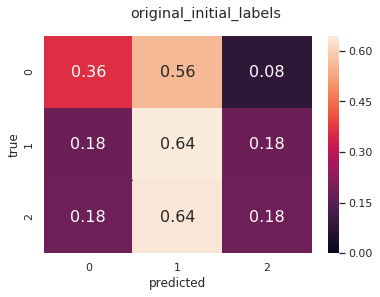

./data/generated_splits/original_new_labels/eval/
['data/generated_splits/original_new_labels/eval/1/IM-0071-0019-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0025-0022-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0028-0011-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0042-0021-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0037-0020-0001.dcm.png']
/data/jma/model/dataset_experiments/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute'

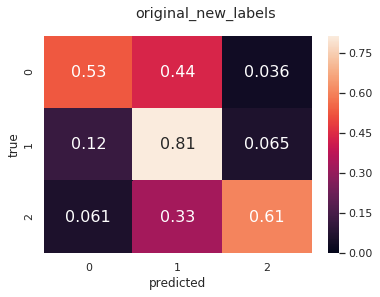

./data/generated_splits/train_set_balanced/eval/
['data/generated_splits/train_set_balanced/eval/1/IM-0040-0029-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0052-0028-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0019-0003-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0063-0024-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0051-0026-0001.dcm.png']
/data/jma/model/dataset_experiments/train_set_balanced/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/train_set_balanced/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, 

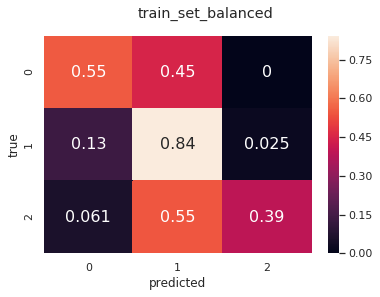

./data/generated_splits/whole_set_balanced/eval/
['data/generated_splits/whole_set_balanced/eval/1/IM-0049-0016-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0026-0015-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0031-0005-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0034-0016-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0032-0030-0001.dcm.png']
/data/jma/model/dataset_experiments/whole_set_balanced/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/whole_set_balanced/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, 

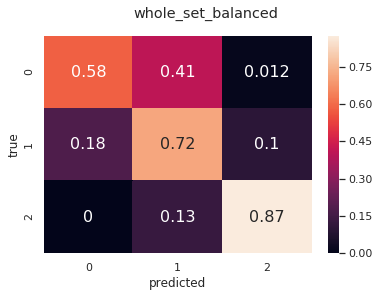

In [75]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["original_initial_labels", "original_new_labels", "train_set_balanced", "whole_set_balanced" ]

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:
                
                eval_root = dataset_root + dt_set + "/eval/"
                   
                print(eval_root)
            
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                print(eval_paths[:5])
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set +"/"
                print(model_path)


                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                            num_channels=filter_size)
                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predicted_labels = list(values)

                cm = tf.confusion_matrix(original_labels, predicted_labels)
                cm = tf.to_float(cm)

                cm = cm.numpy()

                row_sums = cm.sum(axis=1)
                cm = cm / row_sums[:, np.newaxis]

                df_cm = pd.DataFrame(cm, range(3), range(3))
                #plt.figure(figsize = (10,7))

                sns.set(font_scale=1)#for label size
                plt.suptitle(dt_set)
                ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0)# font size
                ax.set(xlabel='predicted', ylabel='true')
                plt.show()
        



## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


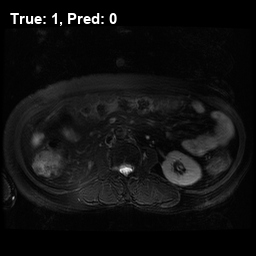

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png//"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    